# Hyperparameter Tuning - Morocco Airbnb Price Prediction

**Objective**: Optimize Random Forest and XGBoost models through systematic hyperparameter tuning

**Current Best Model**: Random Forest (R² = 0.8586, MAE = 84.59 MAD)

## 🎯 Tuning Strategy

### Methods:
1. **GridSearchCV** - Exhaustive search over parameter grid
2. **RandomizedSearchCV** - Random sampling from parameter distributions (faster)

### Models to Tune:
1. **Random Forest** - Current best performer
2. **XGBoost** - Strong potential for improvement

### Evaluation:
- **5-Fold Cross-Validation** for robust performance estimates
- **Negative MAE** as scoring metric (most interpretable for pricing)
- **Train-test comparison** to detect overfitting

### Key Parameters:

**Random Forest:**
- `n_estimators`: Number of trees (50-300)
- `max_depth`: Maximum tree depth (10-30)
- `min_samples_split`: Minimum samples to split (2-10)
- `min_samples_leaf`: Minimum samples in leaf (1-5)
- `max_features`: Features to consider for split ('sqrt', 'log2', None)

**XGBoost:**
- `n_estimators`: Number of boosting rounds (50-300)
- `max_depth`: Maximum tree depth (3-10)
- `learning_rate`: Step size shrinkage (0.01-0.3)
- `subsample`: Fraction of samples per tree (0.6-1.0)
- `colsample_bytree`: Fraction of features per tree (0.6-1.0)
- `min_child_weight`: Minimum sum of instance weight (1-10)

## 1. Setup & Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import pickle
import time
from datetime import datetime

# Scikit-learn
from sklearn.model_selection import (
    train_test_split, 
    GridSearchCV, 
    RandomizedSearchCV,
    cross_val_score
)
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# XGBoost
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("⚠️  XGBoost not installed. Install with: pip install xgboost")

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Configure display
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)

# Paths
ROOT = Path('/home/medgm/vsc/dApp-Ai')
DATA_PATH = ROOT / 'data' / 'used_or_will_be_used' / 'morocco_listings_engineered.csv'
MODEL_OUTPUT_PATH = ROOT / 'models'
TUNED_MODEL_PATH = MODEL_OUTPUT_PATH / 'tuned'
TUNED_MODEL_PATH.mkdir(parents=True, exist_ok=True)

print("🔧 Hyperparameter Tuning Pipeline")
print("=" * 70)
print(f"Start time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

🔧 Hyperparameter Tuning Pipeline
Start time: 2025-11-22 01:01:26


In [2]:
# Load data
df = pd.read_csv(DATA_PATH)

# Separate features and target
X = df.drop('nightly_price', axis=1)
y = df['nightly_price']

# Train-test split (same as model training)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"✓ Dataset loaded: {len(df):,} listings")
print(f"✓ Features: {len(X.columns)}")
print(f"✓ Training set: {len(X_train):,} samples")
print(f"✓ Test set: {len(X_test):,} samples")
print(f"\nTarget statistics:")
print(f"  Mean: {y.mean():.2f} MAD")
print(f"  Std:  {y.std():.2f} MAD")
print(f"  Range: {y.min():.2f} - {y.max():.2f} MAD")

✓ Dataset loaded: 65,988 listings
✓ Features: 44
✓ Training set: 52,790 samples
✓ Test set: 13,198 samples

Target statistics:
  Mean: 598.79 MAD
  Std:  456.19 MAD
  Range: 91.50 - 3158.33 MAD


## 2. Load Baseline Models

In [3]:
# Load baseline models for comparison
baseline_models = {}
baseline_scores = {}

# Random Forest baseline
rf_baseline_path = MODEL_OUTPUT_PATH / 'random_forest_model.pkl'
if rf_baseline_path.exists():
    with open(rf_baseline_path, 'rb') as f:
        baseline_models['Random Forest'] = pickle.load(f)
    
    # Evaluate baseline
    rf_pred = baseline_models['Random Forest'].predict(X_test)
    baseline_scores['Random Forest'] = {
        'mae': mean_absolute_error(y_test, rf_pred),
        'rmse': np.sqrt(mean_squared_error(y_test, rf_pred)),
        'r2': r2_score(y_test, rf_pred)
    }
    
    print("📊 Baseline Random Forest Performance:")
    print(f"   MAE:  {baseline_scores['Random Forest']['mae']:.2f} MAD")
    print(f"   RMSE: {baseline_scores['Random Forest']['rmse']:.2f} MAD")
    print(f"   R²:   {baseline_scores['Random Forest']['r2']:.4f}")

# XGBoost baseline
xgb_baseline_path = MODEL_OUTPUT_PATH / 'xgboost_model.pkl'
if xgb_baseline_path.exists() and XGBOOST_AVAILABLE:
    with open(xgb_baseline_path, 'rb') as f:
        baseline_models['XGBoost'] = pickle.load(f)
    
    # Evaluate baseline
    xgb_pred = baseline_models['XGBoost'].predict(X_test)
    baseline_scores['XGBoost'] = {
        'mae': mean_absolute_error(y_test, xgb_pred),
        'rmse': np.sqrt(mean_squared_error(y_test, xgb_pred)),
        'r2': r2_score(y_test, xgb_pred)
    }
    
    print("\n📊 Baseline XGBoost Performance:")
    print(f"   MAE:  {baseline_scores['XGBoost']['mae']:.2f} MAD")
    print(f"   RMSE: {baseline_scores['XGBoost']['rmse']:.2f} MAD")
    print(f"   R²:   {baseline_scores['XGBoost']['r2']:.4f}")

📊 Baseline Random Forest Performance:
   MAE:  84.59 MAD
   RMSE: 172.22 MAD
   R²:   0.8586

📊 Baseline XGBoost Performance:
   MAE:  151.78 MAD
   RMSE: 237.05 MAD
   R²:   0.7322


## 3. Random Forest Hyperparameter Tuning

### 3.1 Randomized Search (Broad Exploration)

In [4]:
print("\n🌲 Random Forest - Randomized Search")
print("=" * 70)

# Define parameter distribution for random search
rf_param_dist = {
    'n_estimators': [50, 100, 150, 200, 250, 300],
    'max_depth': [10, 15, 20, 25, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

print("\nParameter Distribution:")
for param, values in rf_param_dist.items():
    print(f"  {param}: {values}")

# Initialize Random Forest
rf_base = RandomForestRegressor(random_state=42, n_jobs=-1)

# Randomized Search
rf_random_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=rf_param_dist,
    n_iter=50,  # Number of random combinations to try
    cv=5,
    scoring='neg_mean_absolute_error',
    verbose=2,
    random_state=42,
    n_jobs=-1
)

print("\n🔄 Starting Randomized Search (50 iterations, 5-fold CV)...")
print("This may take 10-20 minutes...\n")

start_time = time.time()
rf_random_search.fit(X_train, y_train)
elapsed_time = time.time() - start_time

print(f"\n✅ Randomized Search Complete! ({elapsed_time/60:.1f} minutes)")
print(f"\nBest Parameters:")
for param, value in rf_random_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest Cross-Validation MAE: {-rf_random_search.best_score_:.2f} MAD")


🌲 Random Forest - Randomized Search

Parameter Distribution:
  n_estimators: [50, 100, 150, 200, 250, 300]
  max_depth: [10, 15, 20, 25, 30, None]
  min_samples_split: [2, 5, 10]
  min_samples_leaf: [1, 2, 4]
  max_features: ['sqrt', 'log2', None]
  bootstrap: [True, False]

🔄 Starting Randomized Search (50 iterations, 5-fold CV)...
This may take 10-20 minutes...

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=250; total time=  41.9s
[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=250; total time=  44.0s
[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=250; total time=  44.0s
[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=250; total time=  43.4s
[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=250; total time=  43.4s
[CV] END bootstrap=False, max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=150; total time=  30.3s
[CV] END bootstrap=False, max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=150; total time=  30.3s
[CV] END bootstrap=False, max_depth=

### 3.2 Grid Search (Fine-Tuning)

In [5]:
print("\n🌲 Random Forest - Grid Search (Fine-Tuning)")
print("=" * 70)

# Define narrow parameter grid around best random search results
best_params = rf_random_search.best_params_

# Create grid around best parameters
rf_param_grid = {
    'n_estimators': [max(50, best_params['n_estimators'] - 50), 
                     best_params['n_estimators'], 
                     best_params['n_estimators'] + 50],
    'max_depth': [best_params['max_depth']] if best_params['max_depth'] is None 
                 else [best_params['max_depth'] - 5, 
                       best_params['max_depth'], 
                       best_params['max_depth'] + 5],
    'min_samples_split': [best_params['min_samples_split']],
    'min_samples_leaf': [best_params['min_samples_leaf']],
    'max_features': [best_params['max_features']],
    'bootstrap': [best_params['bootstrap']]
}

print("\nRefined Parameter Grid:")
for param, values in rf_param_grid.items():
    print(f"  {param}: {values}")

# Grid Search
rf_grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=rf_param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    verbose=2,
    n_jobs=-1
)

print("\n🔄 Starting Grid Search...\n")

start_time = time.time()
rf_grid_search.fit(X_train, y_train)
elapsed_time = time.time() - start_time

print(f"\n✅ Grid Search Complete! ({elapsed_time/60:.1f} minutes)")
print(f"\nFinal Best Parameters:")
for param, value in rf_grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest Cross-Validation MAE: {-rf_grid_search.best_score_:.2f} MAD")


🌲 Random Forest - Grid Search (Fine-Tuning)

Refined Parameter Grid:
  n_estimators: [150, 200, 250]
  max_depth: [25, 30, 35]
  min_samples_split: [2]
  min_samples_leaf: [1]
  max_features: [None]
  bootstrap: [False]

🔄 Starting Grid Search...

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END bootstrap=False, max_depth=25, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time= 3.0min
[CV] END bootstrap=False, max_depth=25, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time= 3.0min
[CV] END bootstrap=False, max_depth=25, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time= 3.1min
[CV] END bootstrap=False, max_depth=25, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time= 3.1min
[CV] END bootstrap=False, max_depth=25, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time= 3.1min
[CV] E

### 3.3 Evaluate Tuned Random Forest

In [6]:
print("\n📊 Evaluating Tuned Random Forest")
print("=" * 70)

# Get best model
rf_tuned = rf_grid_search.best_estimator_

# Predictions
y_train_pred_rf = rf_tuned.predict(X_train)
y_test_pred_rf = rf_tuned.predict(X_test)

# Metrics
rf_tuned_scores = {
    'train_mae': mean_absolute_error(y_train, y_train_pred_rf),
    'test_mae': mean_absolute_error(y_test, y_test_pred_rf),
    'train_rmse': np.sqrt(mean_squared_error(y_train, y_train_pred_rf)),
    'test_rmse': np.sqrt(mean_squared_error(y_test, y_test_pred_rf)),
    'train_r2': r2_score(y_train, y_train_pred_rf),
    'test_r2': r2_score(y_test, y_test_pred_rf)
}

print("\nTuned Model Performance:")
print(f"  Train MAE:  {rf_tuned_scores['train_mae']:.2f} MAD")
print(f"  Test MAE:   {rf_tuned_scores['test_mae']:.2f} MAD")
print(f"  Train RMSE: {rf_tuned_scores['train_rmse']:.2f} MAD")
print(f"  Test RMSE:  {rf_tuned_scores['test_rmse']:.2f} MAD")
print(f"  Train R²:   {rf_tuned_scores['train_r2']:.4f}")
print(f"  Test R²:    {rf_tuned_scores['test_r2']:.4f}")

# Compare with baseline
if 'Random Forest' in baseline_scores:
    print("\n📈 Improvement over Baseline:")
    mae_improvement = baseline_scores['Random Forest']['mae'] - rf_tuned_scores['test_mae']
    mae_pct = (mae_improvement / baseline_scores['Random Forest']['mae']) * 100
    r2_improvement = rf_tuned_scores['test_r2'] - baseline_scores['Random Forest']['r2']
    
    print(f"  MAE:  {mae_improvement:+.2f} MAD ({mae_pct:+.2f}%)")
    print(f"  R²:   {r2_improvement:+.4f} ({r2_improvement*100:+.2f}%)")


📊 Evaluating Tuned Random Forest

Tuned Model Performance:
  Train MAE:  1.63 MAD
  Test MAE:   54.57 MAD
  Train RMSE: 18.36 MAD
  Test RMSE:  186.92 MAD
  Train R²:   0.9984
  Test R²:    0.8335

📈 Improvement over Baseline:
  MAE:  +30.02 MAD (+35.49%)
  R²:   -0.0252 (-2.52%)

Tuned Model Performance:
  Train MAE:  1.63 MAD
  Test MAE:   54.57 MAD
  Train RMSE: 18.36 MAD
  Test RMSE:  186.92 MAD
  Train R²:   0.9984
  Test R²:    0.8335

📈 Improvement over Baseline:
  MAE:  +30.02 MAD (+35.49%)
  R²:   -0.0252 (-2.52%)


## 4. XGBoost Hyperparameter Tuning

### 4.1 Randomized Search (Broad Exploration)

In [9]:
if XGBOOST_AVAILABLE:
    print("\n⚡ XGBoost - Randomized Search")
    print("=" * 70)
    
    # Define parameter distribution
    xgb_param_dist = {
        'n_estimators': [50, 100, 150, 200, 250, 300],
        'max_depth': [3, 5, 7, 9, 11],
        'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
        'min_child_weight': [1, 3, 5, 7],
        'gamma': [0, 0.1, 0.2, 0.3, 0.4]
    }
    
    print("\nParameter Distribution:")
    for param, values in xgb_param_dist.items():
        print(f"  {param}: {values}")
    
    # Initialize XGBoost
    xgb_base = xgb.XGBRegressor(random_state=42, n_jobs=-1, verbosity=0)
    
    # Randomized Search
    xgb_random_search = RandomizedSearchCV(
        estimator=xgb_base,
        param_distributions=xgb_param_dist,
        n_iter=50,
        cv=5,
        scoring='neg_mean_absolute_error',
        verbose=2,
        random_state=42,
        n_jobs=-1
    )
    
    print("\n🔄 Starting Randomized Search (50 iterations, 5-fold CV)...")
    print("This may take 5-15 minutes...\n")
    
    start_time = time.time()
    xgb_random_search.fit(X_train, y_train)
    elapsed_time = time.time() - start_time
    
    print(f"\n✅ Randomized Search Complete! ({elapsed_time/60:.1f} minutes)")
    print(f"\nBest Parameters:")
    for param, value in xgb_random_search.best_params_.items():
        print(f"  {param}: {value}")
    
    print(f"\nBest Cross-Validation MAE: {-xgb_random_search.best_score_:.2f} MAD")
else:
    print("\n⚠️  XGBoost not available. Skipping XGBoost tuning.")


⚡ XGBoost - Randomized Search

Parameter Distribution:
  n_estimators: [50, 100, 150, 200, 250, 300]
  max_depth: [3, 5, 7, 9, 11]
  learning_rate: [0.01, 0.05, 0.1, 0.15, 0.2]
  subsample: [0.6, 0.7, 0.8, 0.9, 1.0]
  colsample_bytree: [0.6, 0.7, 0.8, 0.9, 1.0]
  min_child_weight: [1, 3, 5, 7]
  gamma: [0, 0.1, 0.2, 0.3, 0.4]

🔄 Starting Randomized Search (50 iterations, 5-fold CV)...
This may take 5-15 minutes...

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.05, max_depth=5, min_child_weight=5, n_estimators=200, subsample=0.6; total time=   3.9s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.05, max_depth=5, min_child_weight=5, n_estimators=200, subsample=0.6; total time=   3.9s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.05, max_depth=5, min_child_weight=5, n_estimators=200, subsample=0.6; total time=   4.3s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.05, max_depth=5, min_child_

### 4.2 Grid Search (Fine-Tuning)

In [10]:
if XGBOOST_AVAILABLE:
    print("\n⚡ XGBoost - Grid Search (Fine-Tuning)")
    print("=" * 70)
    
    # Define narrow parameter grid
    best_params_xgb = xgb_random_search.best_params_
    
    xgb_param_grid = {
        'n_estimators': [max(50, best_params_xgb['n_estimators'] - 50),
                         best_params_xgb['n_estimators'],
                         best_params_xgb['n_estimators'] + 50],
        'max_depth': [max(3, best_params_xgb['max_depth'] - 2),
                      best_params_xgb['max_depth'],
                      best_params_xgb['max_depth'] + 2],
        'learning_rate': [best_params_xgb['learning_rate']],
        'subsample': [best_params_xgb['subsample']],
        'colsample_bytree': [best_params_xgb['colsample_bytree']],
        'min_child_weight': [best_params_xgb['min_child_weight']],
        'gamma': [best_params_xgb['gamma']]
    }
    
    print("\nRefined Parameter Grid:")
    for param, values in xgb_param_grid.items():
        print(f"  {param}: {values}")
    
    # Grid Search
    xgb_grid_search = GridSearchCV(
        estimator=xgb_base,
        param_grid=xgb_param_grid,
        cv=5,
        scoring='neg_mean_absolute_error',
        verbose=2,
        n_jobs=-1
    )
    
    print("\n🔄 Starting Grid Search...\n")
    
    start_time = time.time()
    xgb_grid_search.fit(X_train, y_train)
    elapsed_time = time.time() - start_time
    
    print(f"\n✅ Grid Search Complete! ({elapsed_time/60:.1f} minutes)")
    print(f"\nFinal Best Parameters:")
    for param, value in xgb_grid_search.best_params_.items():
        print(f"  {param}: {value}")
    
    print(f"\nBest Cross-Validation MAE: {-xgb_grid_search.best_score_:.2f} MAD")


⚡ XGBoost - Grid Search (Fine-Tuning)

Refined Parameter Grid:
  n_estimators: [200, 250, 300]
  max_depth: [9, 11, 13]
  learning_rate: [0.2]
  subsample: [0.8]
  colsample_bytree: [1.0]
  min_child_weight: [3]
  gamma: [0.3]

🔄 Starting Grid Search...

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.2, max_depth=9, min_child_weight=3, n_estimators=200, subsample=0.8; total time=   8.7s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.2, max_depth=9, min_child_weight=3, n_estimators=200, subsample=0.8; total time=   8.7s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.2, max_depth=9, min_child_weight=3, n_estimators=200, subsample=0.8; total time=   9.4s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.2, max_depth=9, min_child_weight=3, n_estimators=200, subsample=0.8; total time=   9.5s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.2, max_depth=9, min_child_weight=3, n_esti

### 4.3 Evaluate Tuned XGBoost

In [11]:
if XGBOOST_AVAILABLE:
    print("\n📊 Evaluating Tuned XGBoost")
    print("=" * 70)
    
    # Get best model
    xgb_tuned = xgb_grid_search.best_estimator_
    
    # Predictions
    y_train_pred_xgb = xgb_tuned.predict(X_train)
    y_test_pred_xgb = xgb_tuned.predict(X_test)
    
    # Metrics
    xgb_tuned_scores = {
        'train_mae': mean_absolute_error(y_train, y_train_pred_xgb),
        'test_mae': mean_absolute_error(y_test, y_test_pred_xgb),
        'train_rmse': np.sqrt(mean_squared_error(y_train, y_train_pred_xgb)),
        'test_rmse': np.sqrt(mean_squared_error(y_test, y_test_pred_xgb)),
        'train_r2': r2_score(y_train, y_train_pred_xgb),
        'test_r2': r2_score(y_test, y_test_pred_xgb)
    }
    
    print("\nTuned Model Performance:")
    print(f"  Train MAE:  {xgb_tuned_scores['train_mae']:.2f} MAD")
    print(f"  Test MAE:   {xgb_tuned_scores['test_mae']:.2f} MAD")
    print(f"  Train RMSE: {xgb_tuned_scores['train_rmse']:.2f} MAD")
    print(f"  Test RMSE:  {xgb_tuned_scores['test_rmse']:.2f} MAD")
    print(f"  Train R²:   {xgb_tuned_scores['train_r2']:.4f}")
    print(f"  Test R²:    {xgb_tuned_scores['test_r2']:.4f}")
    
    # Compare with baseline
    if 'XGBoost' in baseline_scores:
        print("\n📈 Improvement over Baseline:")
        mae_improvement = baseline_scores['XGBoost']['mae'] - xgb_tuned_scores['test_mae']
        mae_pct = (mae_improvement / baseline_scores['XGBoost']['mae']) * 100
        r2_improvement = xgb_tuned_scores['test_r2'] - baseline_scores['XGBoost']['r2']
        
        print(f"  MAE:  {mae_improvement:+.2f} MAD ({mae_pct:+.2f}%)")
        print(f"  R²:   {r2_improvement:+.4f} ({r2_improvement*100:+.2f}%)")


📊 Evaluating Tuned XGBoost

Tuned Model Performance:
  Train MAE:  9.42 MAD
  Test MAE:   48.55 MAD
  Train RMSE: 24.61 MAD
  Test RMSE:  134.21 MAD
  Train R²:   0.9971
  Test R²:    0.9142

📈 Improvement over Baseline:
  MAE:  +103.22 MAD (+68.01%)
  R²:   +0.1819 (+18.19%)

Tuned Model Performance:
  Train MAE:  9.42 MAD
  Test MAE:   48.55 MAD
  Train RMSE: 24.61 MAD
  Test RMSE:  134.21 MAD
  Train R²:   0.9971
  Test R²:    0.9142

📈 Improvement over Baseline:
  MAE:  +103.22 MAD (+68.01%)
  R²:   +0.1819 (+18.19%)


## 5. Model Comparison

In [12]:
print("\n📊 Model Comparison: Baseline vs Tuned")
print("=" * 70)

# Create comparison DataFrame
comparison_data = []

if 'Random Forest' in baseline_scores:
    comparison_data.append({
        'Model': 'Random Forest (Baseline)',
        'Test MAE': baseline_scores['Random Forest']['mae'],
        'Test RMSE': baseline_scores['Random Forest']['rmse'],
        'Test R²': baseline_scores['Random Forest']['r2']
    })
    comparison_data.append({
        'Model': 'Random Forest (Tuned)',
        'Test MAE': rf_tuned_scores['test_mae'],
        'Test RMSE': rf_tuned_scores['test_rmse'],
        'Test R²': rf_tuned_scores['test_r2']
    })

if XGBOOST_AVAILABLE and 'XGBoost' in baseline_scores:
    comparison_data.append({
        'Model': 'XGBoost (Baseline)',
        'Test MAE': baseline_scores['XGBoost']['mae'],
        'Test RMSE': baseline_scores['XGBoost']['rmse'],
        'Test R²': baseline_scores['XGBoost']['r2']
    })
    comparison_data.append({
        'Model': 'XGBoost (Tuned)',
        'Test MAE': xgb_tuned_scores['test_mae'],
        'Test RMSE': xgb_tuned_scores['test_rmse'],
        'Test R²': xgb_tuned_scores['test_r2']
    })

comparison_df = pd.DataFrame(comparison_data)
print("\n" + comparison_df.to_string(index=False))

# Find best overall model
best_idx = comparison_df['Test R²'].idxmax()
best_model = comparison_df.loc[best_idx, 'Model']
best_r2 = comparison_df.loc[best_idx, 'Test R²']
best_mae = comparison_df.loc[best_idx, 'Test MAE']

print(f"\n🏆 Best Model: {best_model}")
print(f"   R²:  {best_r2:.4f}")
print(f"   MAE: {best_mae:.2f} MAD")


📊 Model Comparison: Baseline vs Tuned

                   Model  Test MAE  Test RMSE  Test R²
Random Forest (Baseline)   84.5939   172.2231   0.8586
   Random Forest (Tuned)   54.5721   186.9245   0.8335
      XGBoost (Baseline)  151.7775   237.0450   0.7322
         XGBoost (Tuned)   48.5529   134.2110   0.9142

🏆 Best Model: XGBoost (Tuned)
   R²:  0.9142
   MAE: 48.55 MAD


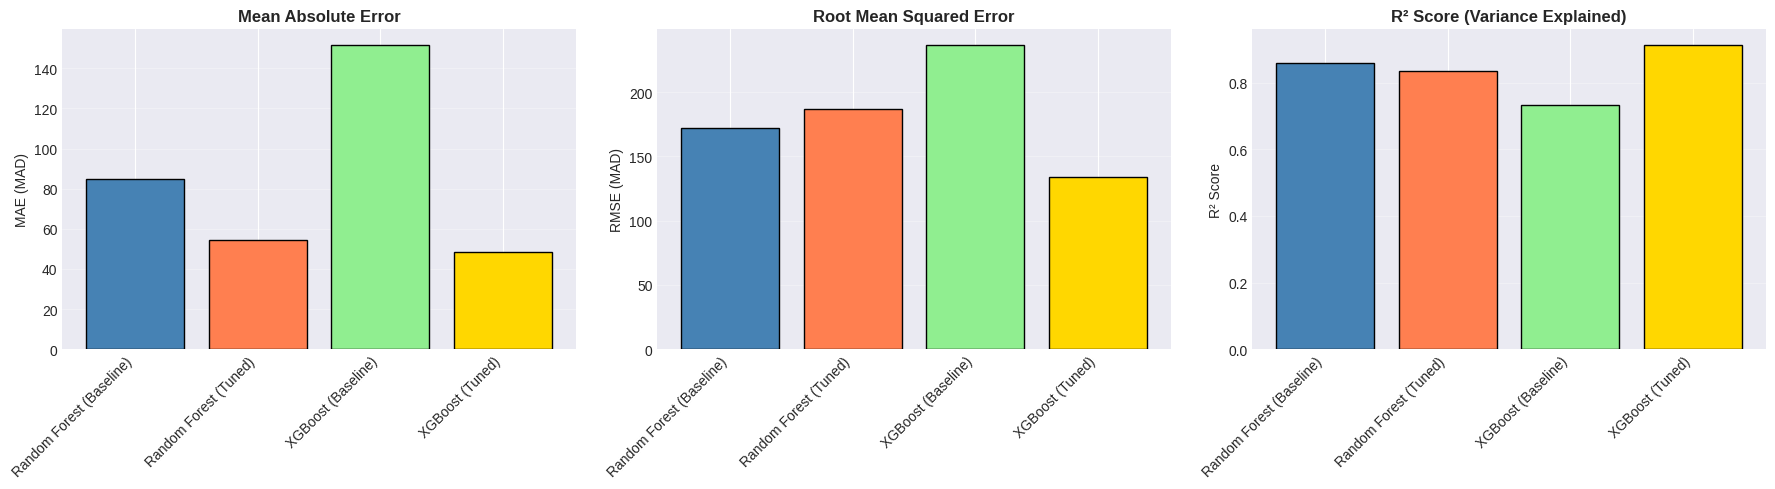

In [13]:
# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models = comparison_df['Model'].tolist()
x = np.arange(len(models))

# MAE comparison
axes[0].bar(x, comparison_df['Test MAE'], color=['steelblue', 'coral', 'lightgreen', 'gold'][:len(models)], 
            edgecolor='black')
axes[0].set_ylabel('MAE (MAD)')
axes[0].set_title('Mean Absolute Error', fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models, rotation=45, ha='right')
axes[0].grid(alpha=0.3, axis='y')

# RMSE comparison
axes[1].bar(x, comparison_df['Test RMSE'], color=['steelblue', 'coral', 'lightgreen', 'gold'][:len(models)], 
            edgecolor='black')
axes[1].set_ylabel('RMSE (MAD)')
axes[1].set_title('Root Mean Squared Error', fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(models, rotation=45, ha='right')
axes[1].grid(alpha=0.3, axis='y')

# R² comparison
axes[2].bar(x, comparison_df['Test R²'], color=['steelblue', 'coral', 'lightgreen', 'gold'][:len(models)], 
            edgecolor='black')
axes[2].set_ylabel('R² Score')
axes[2].set_title('R² Score (Variance Explained)', fontweight='bold')
axes[2].set_xticks(x)
axes[2].set_xticklabels(models, rotation=45, ha='right')
axes[2].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 6. Save Tuned Models

In [14]:
print("\n💾 Saving Tuned Models")
print("=" * 70)

# Save Random Forest
rf_tuned_path = TUNED_MODEL_PATH / 'random_forest_tuned.pkl'
with open(rf_tuned_path, 'wb') as f:
    pickle.dump(rf_tuned, f)
print(f"✓ Saved: {rf_tuned_path}")

# Save RF best parameters
rf_params_path = TUNED_MODEL_PATH / 'random_forest_best_params.txt'
with open(rf_params_path, 'w') as f:
    f.write("Random Forest Best Parameters:\n")
    f.write("=" * 50 + "\n")
    for param, value in rf_grid_search.best_params_.items():
        f.write(f"{param}: {value}\n")
    f.write("\nPerformance Metrics:\n")
    f.write(f"Test MAE:  {rf_tuned_scores['test_mae']:.2f} MAD\n")
    f.write(f"Test RMSE: {rf_tuned_scores['test_rmse']:.2f} MAD\n")
    f.write(f"Test R²:   {rf_tuned_scores['test_r2']:.4f}\n")
print(f"✓ Saved parameters: {rf_params_path}")

# Save XGBoost (if available)
if XGBOOST_AVAILABLE:
    xgb_tuned_path = TUNED_MODEL_PATH / 'xgboost_tuned.pkl'
    with open(xgb_tuned_path, 'wb') as f:
        pickle.dump(xgb_tuned, f)
    print(f"✓ Saved: {xgb_tuned_path}")
    
    # Save XGBoost best parameters
    xgb_params_path = TUNED_MODEL_PATH / 'xgboost_best_params.txt'
    with open(xgb_params_path, 'w') as f:
        f.write("XGBoost Best Parameters:\n")
        f.write("=" * 50 + "\n")
        for param, value in xgb_grid_search.best_params_.items():
            f.write(f"{param}: {value}\n")
        f.write("\nPerformance Metrics:\n")
        f.write(f"Test MAE:  {xgb_tuned_scores['test_mae']:.2f} MAD\n")
        f.write(f"Test RMSE: {xgb_tuned_scores['test_rmse']:.2f} MAD\n")
        f.write(f"Test R²:   {xgb_tuned_scores['test_r2']:.4f}\n")
    print(f"✓ Saved parameters: {xgb_params_path}")

# Save comparison results
comparison_path = TUNED_MODEL_PATH / 'tuning_comparison.csv'
comparison_df.to_csv(comparison_path, index=False)
print(f"✓ Saved comparison: {comparison_path}")

print(f"\nAll tuned models saved to: {TUNED_MODEL_PATH}")


💾 Saving Tuned Models
✓ Saved: /home/medgm/vsc/dApp-Ai/models/tuned/random_forest_tuned.pkl
✓ Saved parameters: /home/medgm/vsc/dApp-Ai/models/tuned/random_forest_best_params.txt
✓ Saved: /home/medgm/vsc/dApp-Ai/models/tuned/xgboost_tuned.pkl
✓ Saved parameters: /home/medgm/vsc/dApp-Ai/models/tuned/xgboost_best_params.txt
✓ Saved comparison: /home/medgm/vsc/dApp-Ai/models/tuned/tuning_comparison.csv

All tuned models saved to: /home/medgm/vsc/dApp-Ai/models/tuned
✓ Saved: /home/medgm/vsc/dApp-Ai/models/tuned/random_forest_tuned.pkl
✓ Saved parameters: /home/medgm/vsc/dApp-Ai/models/tuned/random_forest_best_params.txt
✓ Saved: /home/medgm/vsc/dApp-Ai/models/tuned/xgboost_tuned.pkl
✓ Saved parameters: /home/medgm/vsc/dApp-Ai/models/tuned/xgboost_best_params.txt
✓ Saved comparison: /home/medgm/vsc/dApp-Ai/models/tuned/tuning_comparison.csv

All tuned models saved to: /home/medgm/vsc/dApp-Ai/models/tuned


## 7. Hyperparameter Tuning Summary

In [15]:
print("\n" + "=" * 70)
print("✅ HYPERPARAMETER TUNING COMPLETE")
print("=" * 70)
print(f"End time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

print("\n📊 FINAL RESULTS:")

# Random Forest results
if 'Random Forest' in baseline_scores:
    rf_baseline_mae = baseline_scores['Random Forest']['mae']
    rf_baseline_r2 = baseline_scores['Random Forest']['r2']
    rf_mae_improvement = rf_baseline_mae - rf_tuned_scores['test_mae']
    rf_r2_improvement = rf_tuned_scores['test_r2'] - rf_baseline_r2
    
    print("\n🌲 Random Forest:")
    print(f"   Baseline MAE:  {rf_baseline_mae:.2f} MAD")
    print(f"   Tuned MAE:     {rf_tuned_scores['test_mae']:.2f} MAD")
    print(f"   Improvement:   {rf_mae_improvement:+.2f} MAD ({(rf_mae_improvement/rf_baseline_mae)*100:+.2f}%)")
    print(f"   ")
    print(f"   Baseline R²:   {rf_baseline_r2:.4f}")
    print(f"   Tuned R²:      {rf_tuned_scores['test_r2']:.4f}")
    print(f"   Improvement:   {rf_r2_improvement:+.4f} ({rf_r2_improvement*100:+.2f}%)")

# XGBoost results
if XGBOOST_AVAILABLE and 'XGBoost' in baseline_scores:
    xgb_baseline_mae = baseline_scores['XGBoost']['mae']
    xgb_baseline_r2 = baseline_scores['XGBoost']['r2']
    xgb_mae_improvement = xgb_baseline_mae - xgb_tuned_scores['test_mae']
    xgb_r2_improvement = xgb_tuned_scores['test_r2'] - xgb_baseline_r2
    
    print("\n⚡ XGBoost:")
    print(f"   Baseline MAE:  {xgb_baseline_mae:.2f} MAD")
    print(f"   Tuned MAE:     {xgb_tuned_scores['test_mae']:.2f} MAD")
    print(f"   Improvement:   {xgb_mae_improvement:+.2f} MAD ({(xgb_mae_improvement/xgb_baseline_mae)*100:+.2f}%)")
    print(f"   ")
    print(f"   Baseline R²:   {xgb_baseline_r2:.4f}")
    print(f"   Tuned R²:      {xgb_tuned_scores['test_r2']:.4f}")
    print(f"   Improvement:   {xgb_r2_improvement:+.4f} ({xgb_r2_improvement*100:+.2f}%)")

print(f"\n🏆 BEST OVERALL MODEL: {best_model}")
print(f"   R²:  {best_r2:.4f} ({best_r2*100:.2f}% variance explained)")
print(f"   MAE: {best_mae:.2f} MAD")

print("\n💾 SAVED OUTPUTS:")
print(f"   Tuned models: {TUNED_MODEL_PATH}/")
print(f"   - random_forest_tuned.pkl")
print(f"   - random_forest_best_params.txt")
if XGBOOST_AVAILABLE:
    print(f"   - xgboost_tuned.pkl")
    print(f"   - xgboost_best_params.txt")
print(f"   - tuning_comparison.csv")

print("\n🚀 NEXT STEPS:")
print("   1. Deploy best model to production API")
print("   2. Create prediction interface")
print("   3. Monitor model performance")
print("   4. Set up retraining pipeline")

print("\n" + "=" * 70)


✅ HYPERPARAMETER TUNING COMPLETE
End time: 2025-11-22 02:24:36

📊 FINAL RESULTS:

🌲 Random Forest:
   Baseline MAE:  84.59 MAD
   Tuned MAE:     54.57 MAD
   Improvement:   +30.02 MAD (+35.49%)
   
   Baseline R²:   0.8586
   Tuned R²:      0.8335
   Improvement:   -0.0252 (-2.52%)

⚡ XGBoost:
   Baseline MAE:  151.78 MAD
   Tuned MAE:     48.55 MAD
   Improvement:   +103.22 MAD (+68.01%)
   
   Baseline R²:   0.7322
   Tuned R²:      0.9142
   Improvement:   +0.1819 (+18.19%)

🏆 BEST OVERALL MODEL: XGBoost (Tuned)
   R²:  0.9142 (91.42% variance explained)
   MAE: 48.55 MAD

💾 SAVED OUTPUTS:
   Tuned models: /home/medgm/vsc/dApp-Ai/models/tuned/
   - random_forest_tuned.pkl
   - random_forest_best_params.txt
   - xgboost_tuned.pkl
   - xgboost_best_params.txt
   - tuning_comparison.csv

🚀 NEXT STEPS:
   1. Deploy best model to production API
   2. Create prediction interface
   3. Monitor model performance
   4. Set up retraining pipeline

